# Iteration 4<br/>*One-Hot Encoding*

Jupyter Notebook referenced from my website:: <a href="https://sdiehl28.netlify.com/2018/04/one-hot-encoding-4/" target="_blank">Software Nirvana: One Hot Encoding (4)</a>

### Goals
1. Demonstrate how to One Hot Encode Categorical Variables
2. As part of iterative model development, check if using the categorical variables improves the model's accuracy

### Where We Are
In the third iteration, we created a model which imputed missing Age values by (pclass, sex) by writing a custom Transform class and using it as part of a pipeline.

### What's Next
Make use of non-numeric variables by encoding them as numbers.

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

In [2]:
# read in all the labeled data
all_data = pd.read_csv('../data/train.csv')

In [3]:
# break up the dataframe into X and y
# X is a 2 dimensional "spreadsheet" of values used for prediction
# y is a 1 dimensional vector of target (aka response) values
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']
print('X Shape: ', X.shape)
print('y Shape: ', y.shape)

X Shape:  (891, 11)
y Shape:  (891,)


### Exploratory Data Analysis

The fields that have not yet been examined are: Sex, Name, Ticket, Cabin, Embarked.

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 76.6+ KB


Cabin likely has too many null values to be worthwhile, so this will be dropped.

In [5]:
print('Number of Unique Values')
print(f'Sex:      {X["Sex"].nunique()}')
print(f'Ticket:   {X["Ticket"].nunique()}')
print(f'Embarked: {X["Embarked"].nunique()}')
print(f'Name:     {X["Name"].nunique()}')

Number of Unique Values
Sex:      2
Ticket:   681
Embarked: 3
Name:     891


Perhaps feature extraction could be used with Ticket or Name, however for now these fields will be dropped.

In [6]:
drop_fields = ['Cabin', 'Ticket', 'Name']
X.drop(drop_fields, axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [7]:
rows_to_keep = X['Embarked'].notnull()
X = X.loc[rows_to_keep,:]
y = y.loc[rows_to_keep]
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
PassengerId    889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null object
Age            712 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


Compare Sex and Embarked with Survived.

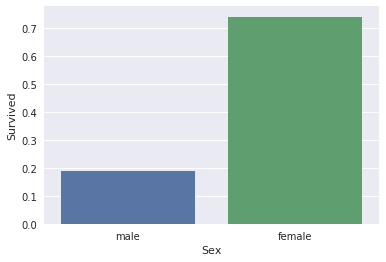

In [8]:
eda_data = X.copy()
eda_data['Survived'] = y
sns.barplot(x='Sex',y='Survived',data=eda_data, ci=None)

Sex will no doubt be an important variable for predicting survival.

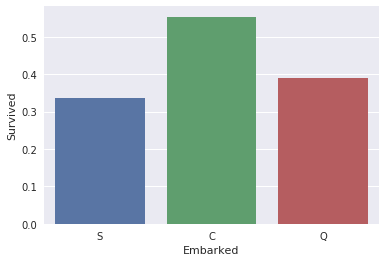

In [9]:
sns.barplot(x='Embarked',y='Survived',data=eda_data, ci=None)

The port of embark may be helpful for predicting survival.

### Encode Sex and Embark Fields
Normally we are concerned with not looking at the test data.  One Hot Encoding does not make implicit use of the test data and can be done for all known values without data leakage.

In [10]:
gender = pd.get_dummies(X['Sex'],drop_first=True)
gender.head(3)

,male
0,1
1,0
2,0


In [11]:
port = pd.get_dummies(X['Embarked'],drop_first=True)
port.head(3)

,Q,S
0,0,1
1,0,0
2,0,1


In [12]:
X = pd.concat([X, gender, port], axis=1)
X.head(3)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,male,Q,S
0,1,3,male,22.0,1,0,7.2500,S,1,0,1
1,2,1,female,38.0,1,0,71.2833,C,0,0,0
2,3,3,female,26.0,0,0,7.9250,S,0,0,1


In [13]:
# Drop the non-numeric fields
# but temporarily keep Sex as it is used for custom Age imputation
X.drop(['Embarked'], axis=1,inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 10 columns):
PassengerId    889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null object
Age            712 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
male           889 non-null uint8
Q              889 non-null uint8
S              889 non-null uint8
dtypes: float64(2), int64(4), object(1), uint8(3)
memory usage: 58.2+ KB


### Model Building

In [14]:
# Use the custom imputation for Age from the previous iteration
from sklearn.base import TransformerMixin
class MyTransformer(TransformerMixin): 
    '''Class with fit() and transform() methods'''

    def fit(self, X, y):
        '''
        fit() will compute and save the mean age per (pclass, sex)
        on the training data
        '''
        self.mean_age_by_pclass_sex = X.groupby(['Pclass', 'Sex'])['Age'].mean()
        
        # return an instance of MyTransformer
        return self
    
    def transform(self, X):
        '''
        transform() is applied to both train and test data
        
        It will replace missing age values by looking up the
        mean age per (pclass,sex)
        '''
        
        # index into multi-indexed Pandas Series using 2-part key
        # Pandas does not allow indexing by DataFrame, so create list of tuples
        # each tuple is (pclass, sex)
        missing_age_idx = X['Age'].isnull()
        df = X.loc[missing_age_idx, ['Pclass', 'Sex']]
        index_tuples = list(df.itertuples(index=False, name=None))
        
        # lookup mean age in DataFrameGroupBy using list of tuples of (pclass, sex)
        imputed_age_values = self.mean_age_by_pclass_sex.loc[index_tuples].values
        
        # replace the missing values with the imputed age values
        X = X.copy()
        X.loc[missing_age_idx, 'Age'] = imputed_age_values

        # drop the sex column as logicstic regression only works with numerics
        # (later we will encode it and use it)
        return X.drop('Sex', axis=1)

In [15]:
# The custom imputation from the previous iteration was shown
# to barely improve the model's accuracy.  Let's not use it here.

# imports
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

k_folds = 10
random_seed=5
crossvalidation = KFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

my_transformer = MyTransformer()

from sklearn.pipeline import make_pipeline
classifier = make_pipeline(my_transformer, LogisticRegression())

# cross_val_score() will properly compute 
# imputation and score per fold
scores = cross_val_score(classifier, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=1)

# save scores for comparison with another iteration
np.save("../data/iter04.data", scores)

print(np.round(scores,3))
print(round(np.mean(scores),3))

[0.865 0.843 0.798 0.787 0.854 0.764 0.809 0.82  0.73  0.727]
0.8


### Compare Model with Previous Iteration

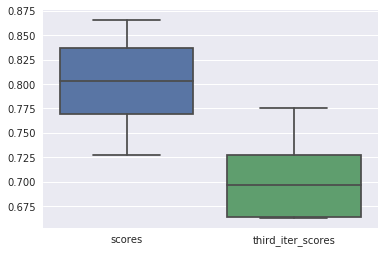

In [16]:
# Read in scores from 3rd iteration
third_iter_scores = np.load('../data/iter03.data.npy')

df = pd.DataFrame(data=list(zip(scores, third_iter_scores)),
                  columns=['scores','third_iter_scores'])
sns.boxplot(data=df)

In [17]:
# the scores in the ordered list correspond with each other as they were
# perform on the same train/test split
diff_scores = scores - third_iter_scores
print(np.round(sorted(diff_scores),3))

[0.011 0.011 0.045 0.053 0.067 0.101 0.124 0.146 0.191 0.199]


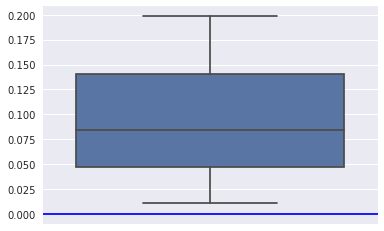

In [18]:
# boxplot the differences and highlight x-axis
sns.boxplot(y=diff_scores)
plt.axhline(0, color='blue')

In [19]:
# How many times is the new model better?
print(f'New Model wins:  {(diff_scores > 0).sum()}')
print(f'New Model ties:  {(diff_scores == 0).sum()}')
print(f'New Model loses: {(diff_scores < 0).sum()}')

New Model wins:  10
New Model ties:  0
New Model loses: 0


### Model Summary
Model Building Steps Only

In [20]:
# read in all the labeled data
all_data = pd.read_csv('../data/train.csv')

# break up the dataframe into X and y
X = all_data.drop('Survived', axis=1)
y = all_data['Survived']

drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']
X = X.drop(drop_cols, axis=1)

gender = pd.get_dummies(X['Sex'],drop_first=True)
port = pd.get_dummies(X['Embarked'],drop_first=True)
X = pd.concat([X, gender, port], axis=1)
X.drop(['Embarked'], axis=1,inplace=True)

k_folds = 10
random_seed=5
crossvalidation = KFold(n_splits=k_folds, shuffle=True, 
                        random_state=random_seed)

# MyTransformer Class defined above
my_transformer = MyTransformer()

classifier = make_pipeline(my_transformer, LogisticRegression())

# cross_val_score() will properly compute 
# imputation and score per fold
scores = cross_val_score(classifier, X, y, cv=crossvalidation, 
                         scoring='accuracy', n_jobs=1)

print(np.round(scores,3))
print(f'Cross Validated Accuracy: {scores.mean():.3f}')

[0.811 0.865 0.809 0.798 0.888 0.798 0.787 0.82  0.73  0.697]
Cross Validated Accuracy: 0.800


### Conclusion

In this iteration we:
* demonstrated one hot encoding for categorical variables
* used previous iteration's custom Age Imputation
* measured the new model's accuracy and found it was much better (80.0% vs 70.5%).